In [1]:
# @title Descarga de dependencias
# Agregamos esta librería que es fundamental para descargar BERT
!pip install sentence-transformers --quiet
!pip install scikit-learn --quiet
!pip install numpy pandas --quiet

In [2]:

# @title Imports iniciales + carga del dataset
import numpy as np
import pandas as pd

# Import para BERT
from sentence_transformers import SentenceTransformer

# Imports para KNN y validación
# Agregamos Normalizer y GridSearchCV para cumplir con las consignas de "escalas" y "hiperparámetros"
from sklearn.model_selection import StratifiedShuffleSplit, train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.metrics import f1_score, classification_report

# Semilla global para reproducibilidad
SEMILLA = 111014
np.random.seed(SEMILLA)

# Ruta de tus archivos (Mantenemos tu lógica)
URL_BASE = '/content/drive/MyDrive/MATERIAS/Ciencia de Datos/nlp-getting-started/'

# Bloque try/except para avisarte si Drive no está montado
df_train = pd.read_csv(URL_BASE + "train.csv")
df_test  = pd.read_csv(URL_BASE + "test.csv")



In [3]:
from urllib.parse import unquote
import re

# 1. Funciones de limpieza (basadas en las tuyas)
def clean_field(text):
    if pd.isna(text):
        return ""
    s = str(text).strip()
    s = unquote(s)
    s = s.replace("&amp;", " and ").replace("&gt;", " ").replace("&lt;", " ")
    s = s.lower()
    s = re.sub(r"\s+", " ", s).strip()
    return s


df_train_knn = df_train.copy()
df_test_knn  = df_test.copy()

df_train_knn["keyword_clean"] = df_train_knn["keyword"].apply(clean_field)
df_test_knn["keyword_clean"]  = df_test_knn["keyword"].apply(clean_field)

def create_bert_text(row):
    kw = row['keyword_clean']
    txt = row['text']

    if kw:
        return f"{kw}. {txt}"
    else:
        return txt

df_train_knn["bert_text"] = df_train_knn.apply(create_bert_text, axis=1)
df_test_knn["bert_text"]  = df_test_knn.apply(create_bert_text, axis=1)

In [4]:
from sentence_transformers import SentenceTransformer
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.metrics import f1_score, classification_report

model = SentenceTransformer('all-MiniLM-L6-v2')
X_embeddings = model.encode(df_train_knn["bert_text"].tolist(), show_progress_bar=True)
y = df_train_knn["target"].values

X_train, X_val, y_train, y_val = train_test_split(
    X_embeddings, y, test_size=0.2, random_state=42, stratify=y
)

/usr/local/lib/python3.12/dist-packages/huggingface_hub/utils/_auth.py:94: UserWarning: 
The secret `HF_TOKEN` does not exist in your Colab secrets.
To authenticate with the Hugging Face Hub, create a token in your settings tab (https://huggingface.co/settings/tokens), set it as secret in your Google Colab and restart your session.
You will be able to reuse this secret in all of your notebooks.
Please note that authentication is recommended but still optional to access public models or datasets.
  warnings.warn(


modules.json:   0%|          | 0.00/349 [00:00<?, ?B/s]

config_sentence_transformers.json:   0%|          | 0.00/116 [00:00<?, ?B/s]

README.md: 0.00B [00:00, ?B/s]

sentence_bert_config.json:   0%|          | 0.00/53.0 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/612 [00:00<?, ?B/s]

model.safetensors:   0%|          | 0.00/90.9M [00:00<?, ?B/s]

tokenizer_config.json:   0%|          | 0.00/350 [00:00<?, ?B/s]

vocab.txt: 0.00B [00:00, ?B/s]

tokenizer.json: 0.00B [00:00, ?B/s]

special_tokens_map.json:   0%|          | 0.00/112 [00:00<?, ?B/s]

config.json:   0%|          | 0.00/190 [00:00<?, ?B/s]

Batches:   0%|          | 0/238 [00:00<?, ?it/s]

In [5]:
# @title Pipeline y Busqueda de hyperparametros

knn_pipeline = Pipeline([
    ('scaler', Normalizer()),
    ('knn', KNeighborsClassifier())
])

param_grid = {
    'knn__n_neighbors': [5, 9, 15, 25, 35],
    'knn__weights': ['distance', 'uniform'],
    'knn__metric': ['euclidean', 'manhattan', 'cosine']
}

grid = GridSearchCV(knn_pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)


GridSearchCV(cv=5,
             estimator=Pipeline(steps=[('scaler', Normalizer()),
                                       ('knn', KNeighborsClassifier())]),
             n_jobs=-1,
             param_grid={'knn__metric': ['euclidean', 'manhattan', 'cosine'],
                         'knn__n_neighbors': [5, 9, 15, 25, 35],
                         'knn__weights': ['distance', 'uniform']},
             scoring='f1')

F1 Score: 0.8045
Accuracy:    0.8037
Precision 0: 0.8519 (No Desastre)
Precision 1: 0.7489 (Desastre)
Recall 0:    0.7940    (No Desastre)
Recall 1:    0.8165    (Desastre)


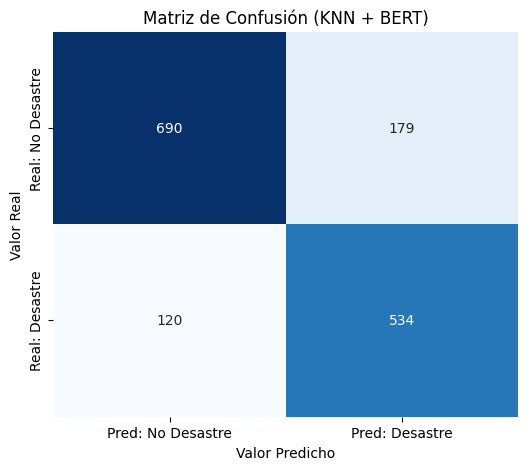

In [6]:
# @title Metricas de validacion
from sklearn.metrics import (
    f1_score,
    accuracy_score,
    precision_score,
    recall_score,
    confusion_matrix
)
import matplotlib.pyplot as plt
import seaborn as sns

best_model = grid.best_estimator_
y_pred_val = best_model.predict(X_val)

# 2. Calcular F1 (Métrica principal del TP)
val_f1 = f1_score(y_val, y_pred_val, average='weighted')

print(f"F1 Score: {val_f1:.4f}")

# La accuracy es una metrica que se mide en:
#Cantidad de aciertos / Totales
# Usando 0.5 de umbral
accuracy = accuracy_score(y_val, y_pred_val)

# La precision es una metrica que se mide en:
# Cuantos Desastres predichos son de verdad desastres
# (Cantidad de 1s correctos / Cantidad de 1s) o lo mismo pero con los 0s
precision_1 = precision_score(y_val, y_pred_val, pos_label=1)
precision_0 = precision_score(y_val, y_pred_val, pos_label=0)


# Es el Analogo de la Precision:
# Recall: Cuantos de los que son de una clase predije como de esa clase?
# 1s Recuperados / Cantidad total de 1s
recall_1 = recall_score(y_val, y_pred_val, pos_label=1)
recall_0 = recall_score(y_val, y_pred_val, pos_label=0)

print(f"Accuracy:    {accuracy:.4f}")
print(f"Precision 0: {precision_0:.4f} (No Desastre)")
print(f"Precision 1: {precision_1:.4f} (Desastre)")
print(f"Recall 0:    {recall_0:.4f}    (No Desastre)")
print(f"Recall 1:    {recall_1:.4f}    (Desastre)")

cm = confusion_matrix(y_val, y_pred_val)

plt.figure(figsize=(6, 5))
sns.heatmap(cm, annot=True, fmt='d', cmap='Blues', cbar=False,
            xticklabels=['Pred: No Desastre', 'Pred: Desastre'],
            yticklabels=['Real: No Desastre', 'Real: Desastre'])
plt.title('Matriz de Confusión (KNN + BERT)')
plt.ylabel('Valor Real')
plt.xlabel('Valor Predicho')
plt.show()

In [7]:


X_test_embeddings = model.encode(df_test_knn["bert_text"].tolist(), show_progress_bar=True)

y_test_pred = best_model.predict(X_test_embeddings)

submission = pd.DataFrame({
    'id': df_test_knn['id'],
    'target': y_test_pred
})

submission.to_csv(URL_BASE + 'submission_knn_bert.csv', index=False)

Batches:   0%|          | 0/102 [00:00<?, ?it/s]

In [8]:
# @title 1. Instalación de Dependencias (Gensim)
!pip install gensim --quiet
!pip install scikit-learn numpy pandas seaborn matplotlib --quiet

import numpy as np
import pandas as pd
import gensim.downloader as api
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.neighbors import KNeighborsClassifier
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import Normalizer
from sklearn.metrics import f1_score, classification_report, accuracy_score, precision_score, recall_score, confusion_matrix
import matplotlib.pyplot as plt
import seaborn as sns

# Semilla
SEMILLA = 111014
np.random.seed(SEMILLA)

# Carga de datos
URL_BASE = '/content/drive/MyDrive/MATERIAS/Ciencia de Datos/nlp-getting-started/'
try:df_train = pd.read_csv(URL_BASE + "train.csv")
df_test  = pd.read_csv(URL_BASE + "test.csv")


glove_model = api.load("glove-twitter-100")


   ━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━ 27.9/27.9 MB 40.0 MB/s eta 0:00:00
Descargando vectores GloVe (puede tardar un minuto)...
[==================================================] 100.0% 387.1/387.1MB downloaded
¡GloVe cargado!


In [9]:
# @title 2. Preprocesamiento y Vectorización GloVe
from urllib.parse import unquote
import re

# Tu función de limpieza (Mantenemos tu lógica)
def clean_field(text):
    if pd.isna(text):
        return ""
    s = str(text).strip()
    s = unquote(s)
    s = s.replace("&amp;", " and ").replace("&gt;", " ").replace("&lt;", " ")
    s = s.lower()
    s = re.sub(r"\s+", " ", s).strip()
    return s

# Aplicamos limpieza
df_train_knn = df_train.copy()
df_train_knn["keyword_clean"] = df_train_knn["keyword"].apply(clean_field)

# Creamos el texto conjunto (Keyword + Texto)
def create_text_concat(row):
    kw = row['keyword_clean']
    txt = str(row['text']).lower() # Aseguramos minusculas para GloVe
    if kw:
        return f"{kw} {txt}" # Concatenamos con espacio
    else:
        return txt

df_train_knn["clean_text"] = df_train_knn.apply(create_text_concat, axis=1)

def vectorize_with_glove(text_list, model):
    vectors = []
    for text in text_list:
        words = str(text).split()

        word_vectors = [model[w] for w in words if w in model]

        if len(word_vectors) == 0:
            vectors.append(np.zeros(model.vector_size))
        else:
            vectors.append(np.mean(word_vectors, axis=0))

    return np.array(vectors)

print("Vectorizando tweets con GloVe...")
X_embeddings = vectorize_with_glove(df_train_knn["clean_text"].tolist(), glove_model)
y = df_train_knn["target"].values

X_train, X_val, y_train, y_val = train_test_split(
    X_embeddings, y, test_size=0.2, random_state=42, stratify=y
)

print(f"Shape de X_train: {X_train.shape}")

Vectorizando tweets con GloVe...
Shape de X_train: (6090, 100)


Iniciando GridSearch (esto puede tardar un poco)...

MEJORES PARÁMETROS: {'knn__metric': 'euclidean', 'knn__n_neighbors': 10, 'knn__weights': 'distance'}
F1 Score:    0.7905
Accuracy:    0.7905
Precision 1: 0.7573
Recall 1:    0.7538


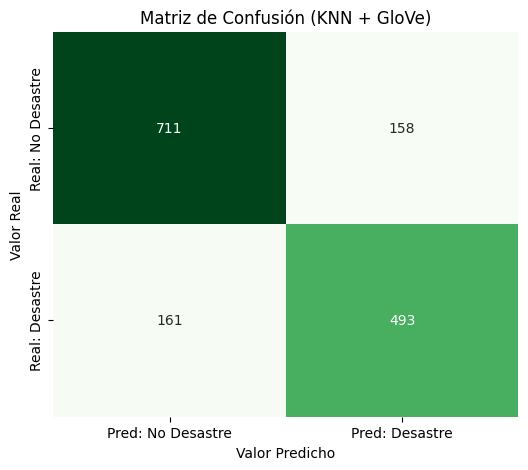

In [10]:
# @title 3. Pipeline, GridSearch y Evaluación

# Pipeline
knn_pipeline = Pipeline([
    ('scaler', Normalizer()),
    ('knn', KNeighborsClassifier())
])

# Grid de Hiperparámetros
param_grid = {
    'knn__n_neighbors': [5, 10, 15, 25, 50],
    'knn__weights': ['distance', 'uniform'],
    'knn__metric': ['euclidean', 'manhattan']
}

grid = GridSearchCV(knn_pipeline, param_grid, cv=5, scoring='f1', n_jobs=-1)
grid.fit(X_train, y_train)

best_model = grid.best_estimator_
y_pred_val = best_model.predict(X_val)

val_f1 = f1_score(y_val, y_pred_val, average='weighted')
accuracy = accuracy_score(y_val, y_pred_val)
precision_1 = precision_score(y_val, y_pred_val, pos_label=1)
recall_1 = recall_score(y_val, y_pred_val, pos_label=1)

print(f"F1 Score:    {val_f1:.4f}")
print(f"Accuracy:    {accuracy:.4f}")
print(f"Precision 1: {precision_1:.4f}")
print(f"Recall 1:    {recall_1:.4f}")